In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meat-preperation-survey/RaguseaMeatWashingSurveyResponsesRaw.csv


# 1. Introduction

We are going to inspect the security concerns of people by using the survey data.

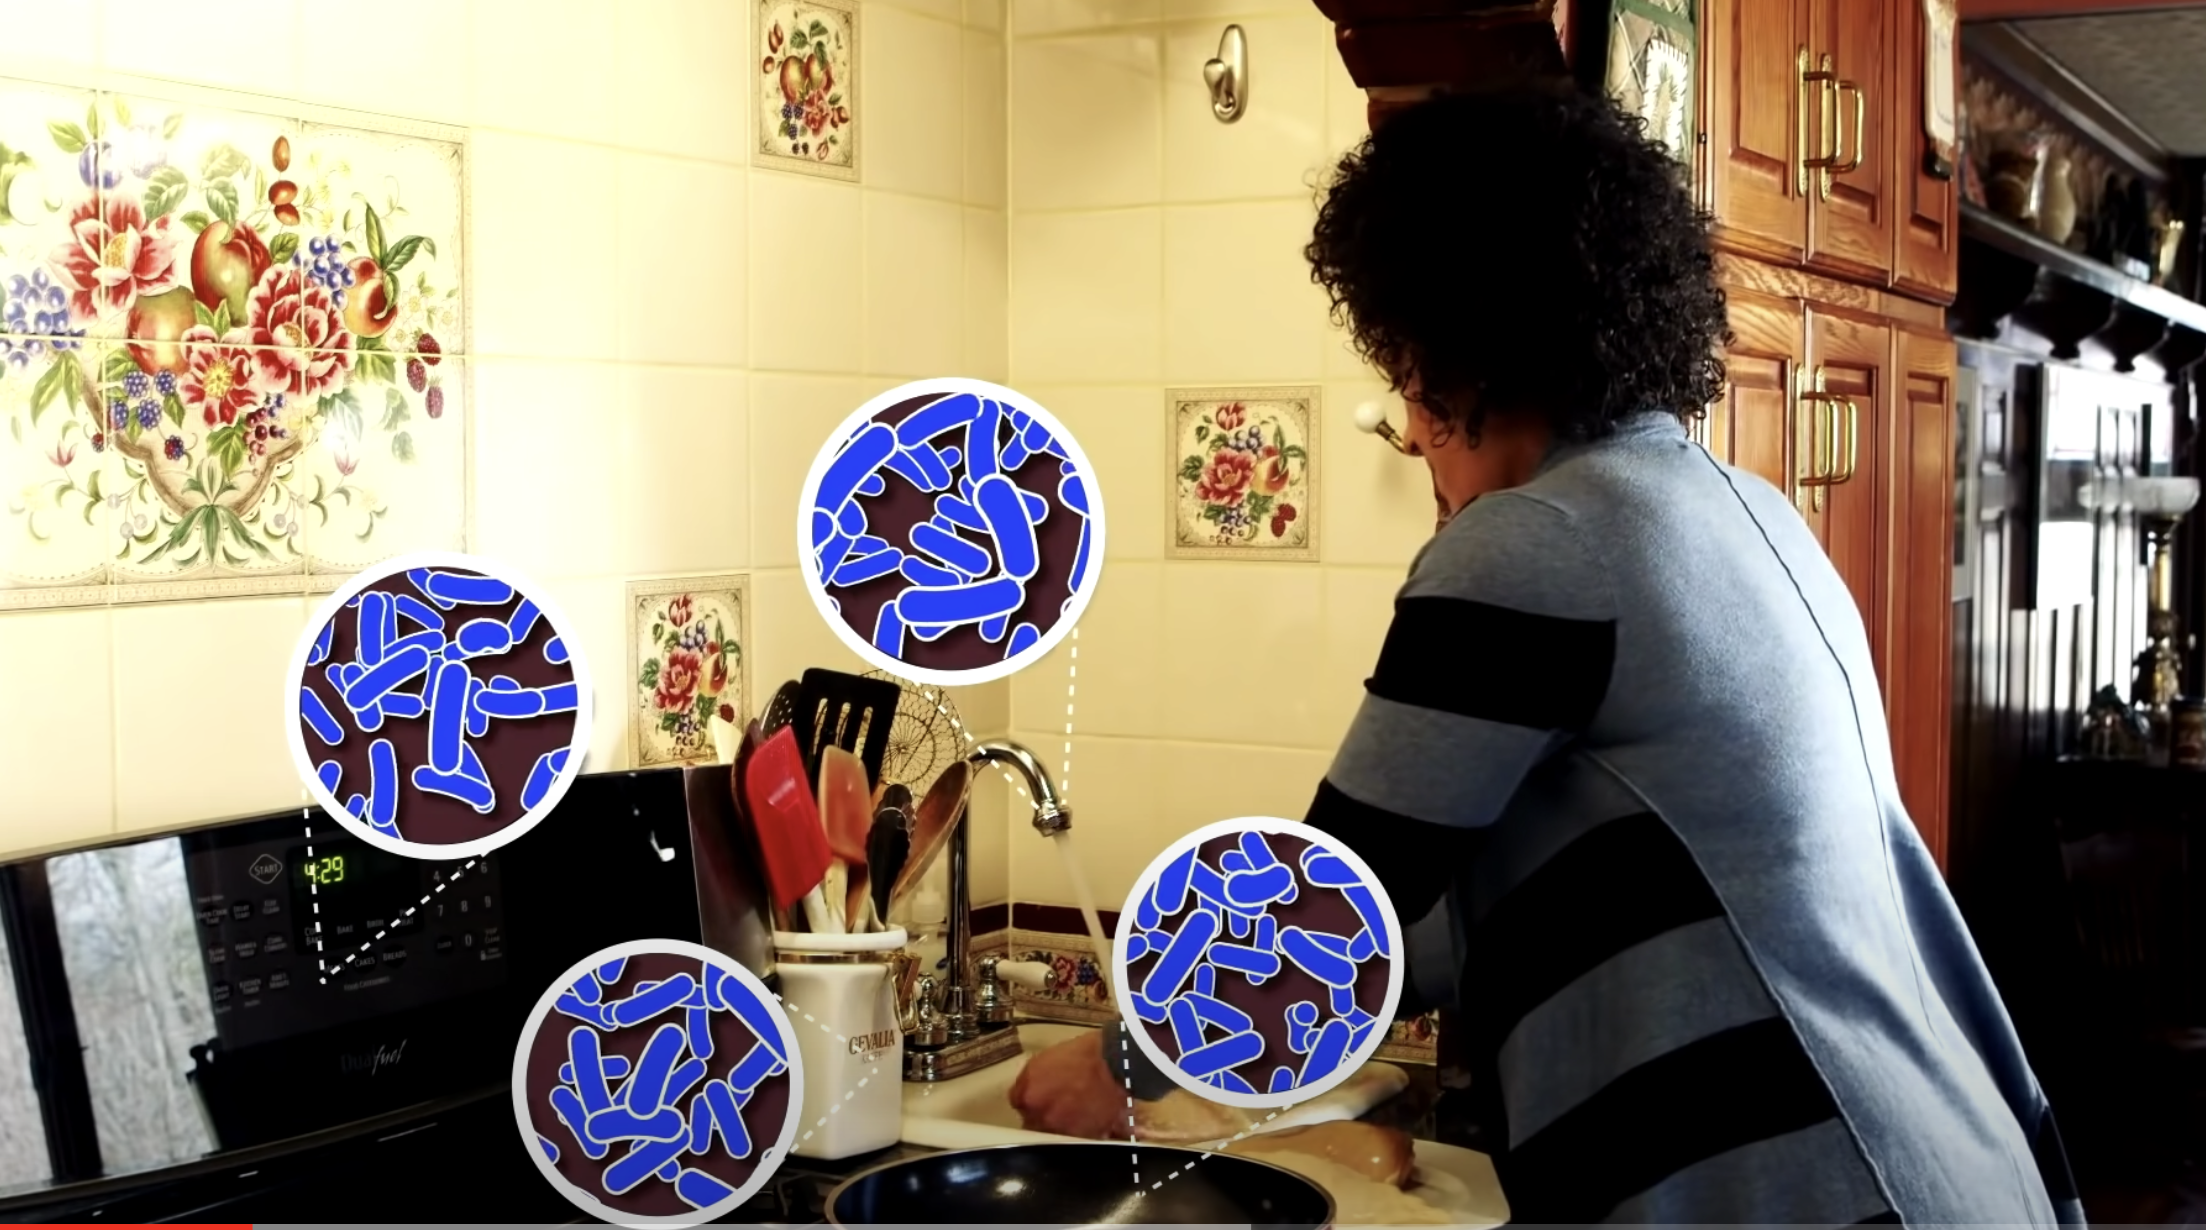

# 2. Data ETL process

**2.1 Initial data cleaning**

In this part, we are going to load the data, drop the useful part. We can see there are many questions in this survey. We set thresh hold at 0.9 to remove the columns with NAN values. After this process, there are still 18 columns. 

In [30]:
import pandas as pd

url = '/kaggle/input/meat-preperation-survey/RaguseaMeatWashingSurveyResponsesRaw.csv'
df = pd.read_csv(url, sep=',', on_bad_lines='skip', engine='python')

columns_to_drop = list(df.filter(like='If you').columns)
df = df.drop(columns=columns_to_drop)

thresh = len(df) * 0.9  # keep columns with at least 50% non-NaN values
df = df.dropna(thresh=thresh, axis=1)
df = df.dropna(subset=df.columns, how='any')

header_list = list(df.columns)
header_list = [header for header in header_list if header.strip()]

for header in header_list:
    print(header)

original_names = df.columns

print(df.shape)

Timestamp
Do you prepare meat for yourself or others ?
What is your current age? 
What is your gender ? (Self-describe using 'other.')
Identify your country or territory of origin
Identify your current country or territory of residency
How often do you prepare a meal in your household?
How many people are in your household?
How  important is food safety to you when you cook?
Which of the following do you do regularly when cooking, preparing and consuming food products? (Check all that apply)
Before you begin to prepare food in your kitchen, how often do you wash your hands with soap and warm water for at least 20 seconds?
Please indicate how often you do each of the following [Use different plates for handling raw meat and cooked meat]
Please indicate how often you do each of the following [Use a food thermometer to check the doneness for red meat, pork or poultry]
Please indicate how often you do each of the following [Not wash utensils used to handle raw food before they are used for

**2.2 Remove the headers, use the second line as the header**


In [31]:
df = df.iloc[0:]

new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

header_list = list(df.columns)
header_list = [header for header in header_list if header.strip()]

for header in header_list:
  print(header)

original_names = df.columns

# save the DataFrame to a CSV file
df.to_csv('RaguseaSurvey_short.csv', index=False)

print('File saved successfully!')

Timestamp
Prep Meat?
Age
Gender
Country Origin
Country Residence
Prep Often
Houshold size
Food Safety Important
Do regularly?
20 second wash
Different plates?
Thermometer?
NOT wash between utensils?
NOT was between cutting boards?
Leave food out 2hrs or more
When you eat at someone's house, how important is it to you that they be attentive to food safety in their food preparation?
When you eat at a commercial eatery, how important is it to you that they be attentive to food safety in their food preparation?
File saved successfully!


**2.3 Choose columns**

The survey The survey consists of many questions, we can seperate into two parts, one is about attitude, another part is focusing on about cooking habits. This time, we focus on attitude.We decide to make initial analysis about this by filtering the columns that we concerns. We only choose the people who resides in united states of America and cook often. 



In [32]:
# Select the specified columns
selected_columns = df[['Timestamp', 'Prep Meat?', 'Age', 'Gender', 
                       'Country Origin','Country Residence', 'Prep Often',
                       'Houshold size', 'Food Safety Important',
                       'When you eat at someone\'s house, how important is it to you that they be attentive to food safety in their food preparation?',
                       'When you eat at a commercial eatery, how important is it to you that they be attentive to food safety in their food preparation?']]
df = selected_columns

df = df.rename(columns={
    'When you eat at someone\'s house, how important is it to you that they be attentive to food safety in their food preparation?': 
    'ImpSomeonesHouse',
    'When you eat at a commercial eatery, how important is it to you that they be attentive to food safety in their food preparation?': 
    'ImpComercial',  
    'Food Safety Important': 'ImpWhenCook'
})

print(df.describe())

0           Timestamp Prep Meat?    Age Gender            Country Origin  \
count           13010      13010  13010  13010                     13010   
unique           3506          3     73     36                       160   
top     9/28/20 14:40      Often     23   Male  United States of America   
freq               46       8181    904  10944                      5840   

0              Country Residence Prep Often Houshold size ImpWhenCook  \
count                      13010      13010         13010       13010   
unique                       133          4            28           5   
top     United States of America      Often             2           4   
freq                        6270       9525          3854        6000   

0      ImpSomeonesHouse ImpComercial  
count             13010        13010  
unique                5            5  
top                   4            5  
freq               5519         9503  


**2.4 Initial Data Filtering**

In [33]:
import pandas as pd

# Assuming you have a DataFrame called df
filtered_df = df[(df['Country Origin'] == 'United States of America') & (df['Country Residence'] == 'United States of America')]
df = filtered_df

filtered_df = df[(df['Prep Meat?'] == 'Often') & (df['Prep Often'] == 'Often')]
df = filtered_df

filtered_df = df[(df['Gender'] == 'Male') | (df['Gender'] == 'Female')]

df = filtered_df

############################################################################
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Houshold size'] = pd.to_numeric(df['Houshold size'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

df['ImpWhenCook'] = pd.to_numeric(df['ImpWhenCook'], errors='coerce')
df['ImpSomeonesHouse'] = pd.to_numeric(df['ImpSomeonesHouse'], errors='coerce')
df['ImpComercial'] = pd.to_numeric(df['ImpComercial'], errors='coerce')

# Encode Gender
df['Gender'] = df['Gender'].astype('category')
df['Gender'] = df['Gender'].cat.codes

# Drop NA values
df = df.dropna(subset=['Age', 'Gender', 'Houshold size',
                       'ImpSomeonesHouse',
                       'ImpComercial',
                       'ImpWhenCook'])

print(df.describe())
print(df.shape)

# Display the timestamp distribution
timestamp_distribution = df['Timestamp'].describe(datetime_is_numeric=True)
print(timestamp_distribution)

0              Age       Gender  Houshold size  ImpWhenCook  ImpSomeonesHouse  \
count  3371.000000  3371.000000    3371.000000  3371.000000       3371.000000   
mean     29.383269     0.883121       2.666642     4.242658          3.978048   
std       9.844289     0.321324       1.388347     0.746009          0.908642   
min      12.000000     0.000000       1.000000     1.000000          1.000000   
25%      23.000000     1.000000       2.000000     4.000000          3.000000   
50%      27.000000     1.000000       2.000000     4.000000          4.000000   
75%      33.500000     1.000000       4.000000     5.000000          5.000000   
max      79.000000     1.000000      15.000000     5.000000          5.000000   

0      ImpComercial  
count   3371.000000  
mean       4.700682  
std        0.642461  
min        1.000000  
25%        5.000000  
50%        5.000000  
75%        5.000000  
max        5.000000  
(3371, 11)
count                             3371
mean     2020-09-29 08

# 3. EDA and Visualization

**3.1 Data visualization**

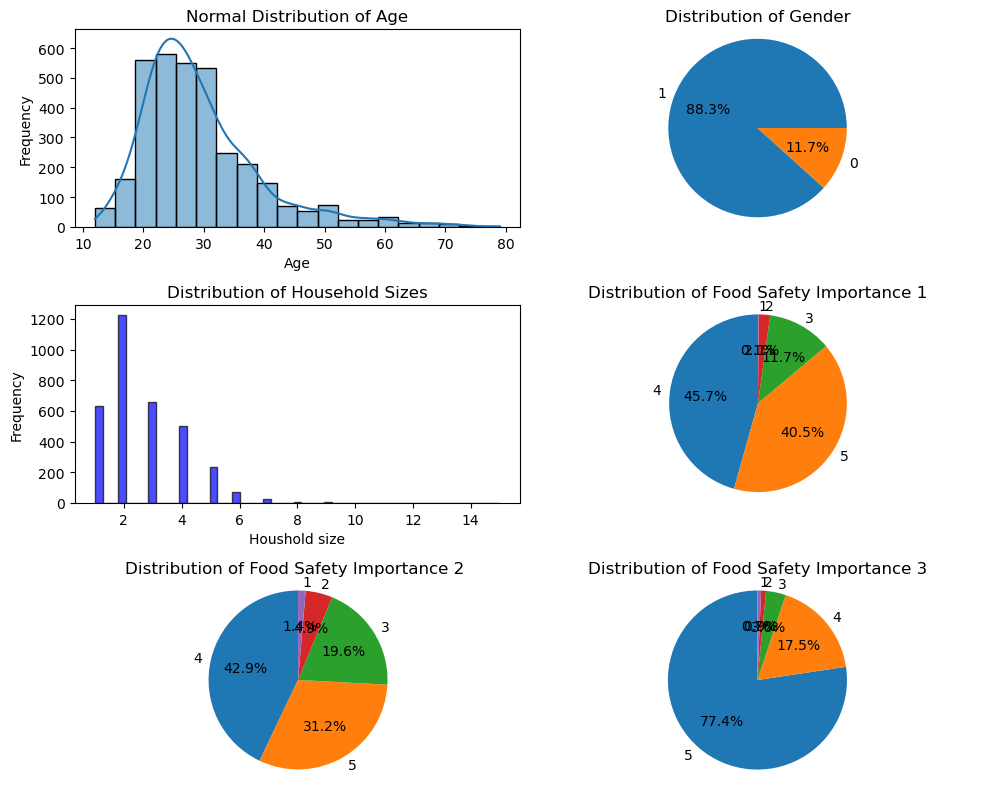

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
    
# Preprocess the DataFrame
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df = df.dropna(subset=['Age'])

def chartAge(ax):
    sns.histplot(data=df, x='Age', bins=20, kde=True, ax=ax)
    ax.set_title('Normal Distribution of Age')
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')

def chartGender(ax):
    gender_counts = df['Gender'].value_counts()
    ax.pie(gender_counts.values, labels=gender_counts.index, autopct='%.1f%%')
    ax.set_title("Distribution of Gender")
    ax.axis('equal')

def chartHousehold(ax):
    ax.hist(df['Houshold size'], bins='auto', color='blue', edgecolor='black', alpha=0.7)
    ax.set_title('Distribution of Household Sizes')
    ax.set_xlabel('Houshold size')
    ax.set_ylabel('Frequency')

def chartSafe1(ax):
    value_counts = df['ImpWhenCook'].value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%.1f%%', startangle=90)
    ax.set_title('Distribution of Food Safety Importance 1')
    ax.axis('equal')

def chartSafe2(ax):
    value_counts = df['ImpSomeonesHouse'].value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%.1f%%', startangle=90)
    ax.set_title('Distribution of Food Safety Importance 2 ')
    ax.axis('equal')
    
def chartSafe3(ax):
    value_counts = df['ImpComercial'].value_counts()
    ax.pie(value_counts, labels=value_counts.index, autopct='%.1f%%', startangle=90)
    ax.set_title('Distribution of Food Safety Importance 3')
    ax.axis('equal')

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))

chartAge(axes[0, 0])
chartGender(axes[0, 1])
chartHousehold(axes[1, 0])
chartSafe1(axes[1, 1])
chartSafe2(axes[2, 0])
chartSafe3(axes[2, 1])

fig.tight_layout()

plt.show()

**3.2 Correlation Analysis**

In [66]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Extract the features to be used in NMF
X = df[["Age", "Gender", "ImpComercial", "ImpSomeonesHouse",'ImpWhenCook','Houshold size']].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_cluster)
X_scaled[X_scaled < 0] = 0

nmf = NMF(n_components=3, init='nndsvda', max_iter=500)
W = nmf.fit_transform(X_scaled)
H = nmf.components_

# Print the resulting factor loadings (H)
print(H)

# Display the resulting clusters
cluster_labels = W.argmax(axis=1)
print(cluster_labels)


[[0.95514588 3.64216723 0.         0.         1.17742969 6.3905437 ]
 [1.20308416 0.         3.77449434 3.88793994 3.76242955 0.7976742 ]
 [0.46244677 3.33483788 2.71973044 1.87405658 1.91777718 0.        ]]
[1 0 0 ... 2 2 2]


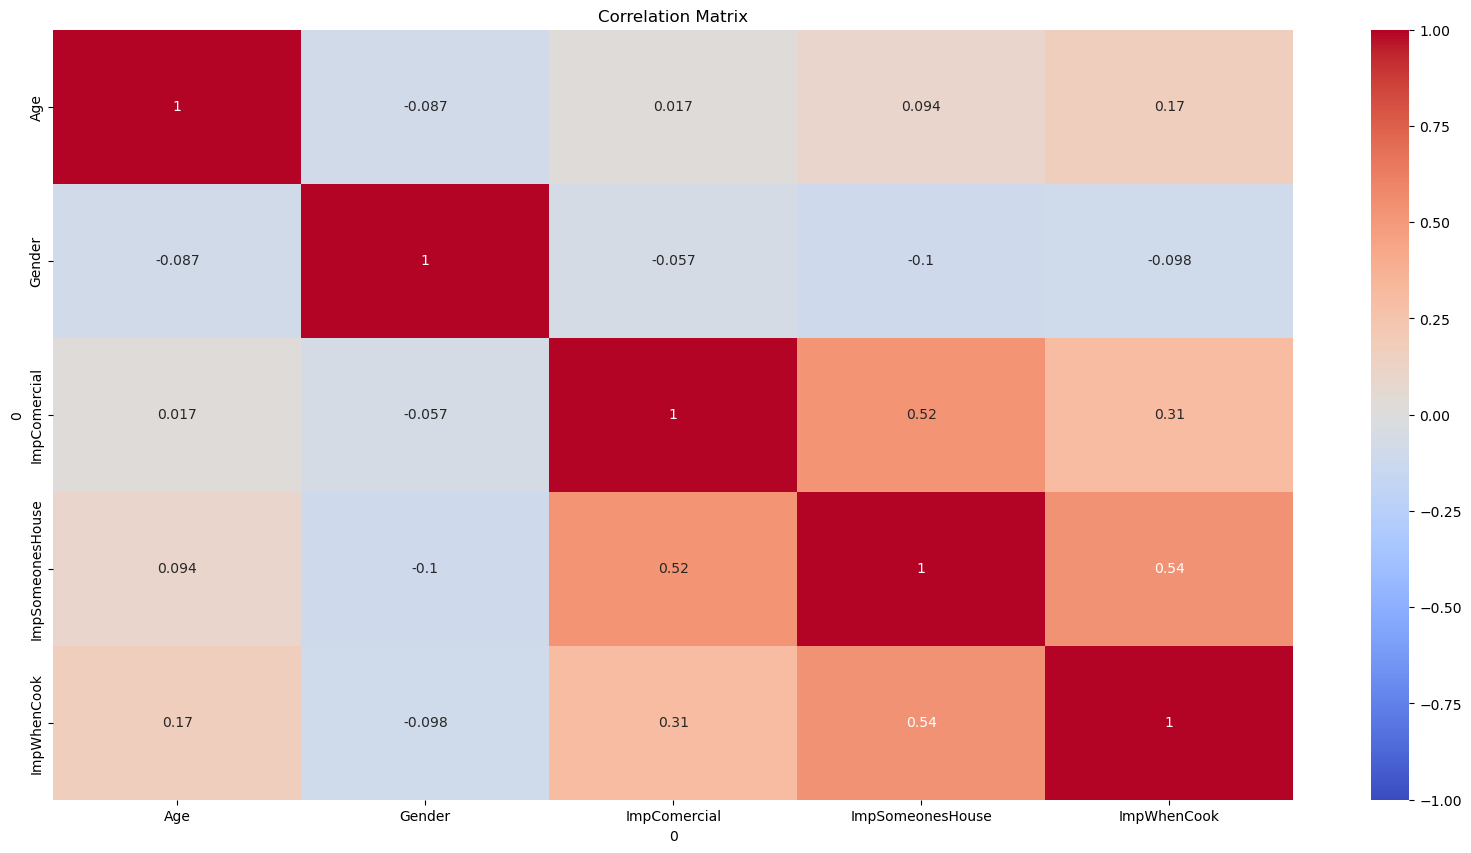

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df[['Age', 'Gender', 'ImpComercial', 'ImpSomeonesHouse','ImpWhenCook']].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

1. Age and Gender: With a correlation of -0.087, there is a very weak negative correlation between Age and Gender. This suggests that there is no significant relationship between the two variables.

2. Age and ImpWhenCook: A correlation of 0.17 indicates a weak positive relationship between Age and Food Safety Important. This suggests that as people get older, they might be slightly more likely to consider food safety important. However, the correlation is weak, so it's not a strong relationship.

3. Gender and ImpWhenCook: With a correlation of -0.098, there is a very weak negative correlation between Gender and Food Safety Important. This implies that there is no significant relationship between these two variables.

4. ImpWhenCook and ImpComercial is 0.52 shows strong relationship between these two factors.

5. ImpWhenCook and ImpSomeoneHouse is 0.54 shows strong relationship between these two factors.

In summary, beside the ImpWhenCook and ImpSomeoneHouse or ImpCommercial, the correlation values provided suggest that there are no strong relationships between the fields in this dataset. The correlations between Age and Food Safety Important and Age are weak, indicating that these relationships exist but are not particularly strong. 

# 4. Segmentation

Since the correlations between variables are weak or close to zero, it may indicate that the variables are not linearly related. However, this doesn't necessarily mean that there is no relationship at all – there might be nonlinear relationships or hidden patterns in the data that are not captured by simple correlation coefficients

**4.1 K-means Clustering**

In [41]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_cluster = df[["Age", "Gender", "ImpComercial", "ImpSomeonesHouse",'ImpWhenCook']]

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

k = 3
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_scaled)
labels = kmeans.labels_


df_cluster = df[["Age", "Gender", "ImpComercial", "ImpSomeonesHouse",'ImpWhenCook']].copy()
df_cluster['Cluster'] = labels

# Create pair plots with different colors for each cluster
# sns.pairplot(df_cluster, hue='Cluster', diag_kind='hist', markers='o', palette='viridis')

# Show the plot
# plt.show()


Show the result in a table.

In [42]:
from prettytable import PrettyTable

# Group the data by the cluster labels
groups = df_cluster.groupby('Cluster')

# Compute the mean, min, and max values for each column in each group
summary = groups.agg(['mean', 'min', 'max'])

# Create a pretty table for the summary data
table = PrettyTable()
table.field_names = ["Cluster", "Age (min/max)", "Gender (min/max)", 
                     "ImpComercial (min/max)", "ImpSomeonesHouse (min/max)", "ImpWhenCook (min/max)"]

# Add a row for each cluster
for i in range(len(summary)):
    cluster_num = i+1
    age_min = round(summary.iloc[i]['Age']['min'], 2)
    age_max = round(summary.iloc[i]['Age']['max'], 2)
    gender_min = round(summary.iloc[i]['Gender']['min'], 2)
    gender_max = round(summary.iloc[i]['Gender']['max'], 2)
    imp_com_min = round(summary.iloc[i]['ImpComercial']['min'], 2)
    imp_com_max = round(summary.iloc[i]['ImpComercial']['max'], 2)
    imp_house_min = round(summary.iloc[i]['ImpSomeonesHouse']['min'], 2)
    imp_house_max = round(summary.iloc[i]['ImpSomeonesHouse']['max'], 2)
    imp_cook_min = round(summary.iloc[i]['ImpWhenCook']['min'], 2)
    imp_cook_max = round(summary.iloc[i]['ImpWhenCook']['max'], 2)
    
    row_data = [cluster_num, f"{age_min} - {age_max}", f"{gender_min} - {gender_max}",
                f"{imp_com_min} - {imp_com_max}", f"{imp_house_min} - {imp_house_max}",
                f"{imp_cook_min} - {imp_cook_max}"]
    
    table.add_row(row_data)

# Print the table
print(table)


+---------+---------------+------------------+------------------------+----------------------------+-----------------------+
| Cluster | Age (min/max) | Gender (min/max) | ImpComercial (min/max) | ImpSomeonesHouse (min/max) | ImpWhenCook (min/max) |
+---------+---------------+------------------+------------------------+----------------------------+-----------------------+
|    1    |  13.0 - 79.0  |    1.0 - 1.0     |       3.0 - 5.0        |         2.0 - 5.0          |       3.0 - 5.0       |
|    2    |  14.0 - 73.0  |    0.0 - 0.0     |       3.0 - 5.0        |         1.0 - 5.0          |       3.0 - 5.0       |
|    3    |  12.0 - 72.0  |    0.0 - 1.0     |       1.0 - 5.0        |         1.0 - 5.0          |       1.0 - 5.0       |
+---------+---------------+------------------+------------------------+----------------------------+-----------------------+


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


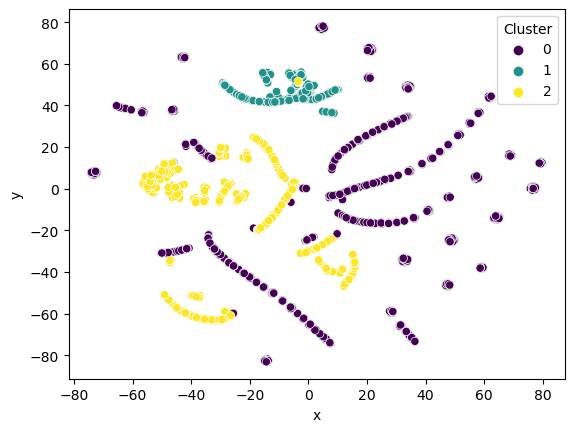

In [43]:
import seaborn as sns
from sklearn.manifold import TSNE

# Fit and transform the data using t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_scaled)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
df_tsne = pd.DataFrame({'x': X_tsne[:, 0], 'y': X_tsne[:, 1], 'Cluster': labels})

sns.scatterplot(data=df_tsne, x='x', y='y', hue='Cluster', palette='viridis')
plt.show()


**4.2 Hierarchical Clustering**

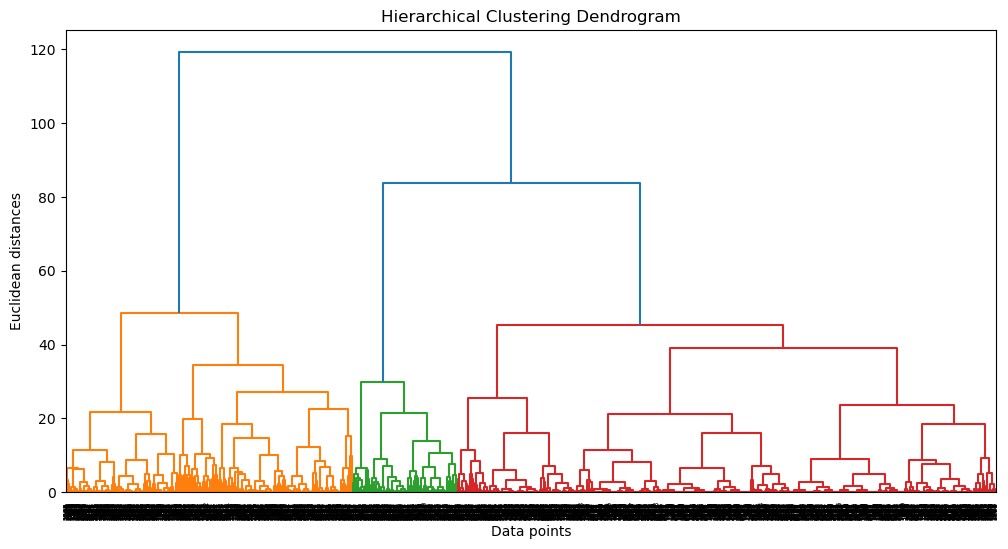

In [44]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Perform hierarchical clustering using the "ward" linkage method
Z = linkage(df_scaled, method="ward")

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data points")
plt.ylabel("Euclidean distances")
plt.show()

In [55]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Assign each data point to a cluster based on the distance criterion
df_cluster['Cluster'] = fcluster(Z, 15, criterion='distance')

# Define the number of top clusters to show in the summary table
top_clusters = 3

# Group the data by the cluster labels
groups = df_cluster.groupby('Cluster')

# Compute the mean, min, and max values for each column in each group
summary = groups.agg(['min', 'max'])

# Create a table to display the summary statistics
table = PrettyTable()
table.field_names = ["Cluster", "Age (min/max)", "Gender (min/max)", "ImpComercial (min/max)", "ImpSomeonesHouse (min/max)", "ImpWhenCook (min/max)"]

# Loop through the clusters and add a row for each one to the table
for i in summary.index:
    row = []
    row.append(i)
    row.append(f"{summary.loc[i, ('Age', 'min')]} - {summary.loc[i, ('Age', 'max')]}")
    row.append(f"{summary.loc[i, ('Gender', 'min')]} - {summary.loc[i, ('Gender', 'max')]}")
    row.append(f"{summary.loc[i, ('ImpComercial', 'min')]} - {summary.loc[i, ('ImpComercial', 'max')]}")
    row.append(f"{summary.loc[i, ('ImpSomeonesHouse', 'min')]} - {summary.loc[i, ('ImpSomeonesHouse', 'max')]}")
    row.append(f"{summary.loc[i, ('ImpWhenCook', 'min')]} - {summary.loc[i, ('ImpWhenCook', 'max')]}")
    table.add_row(row)

print(table)


+---------+---------------+------------------+------------------------+----------------------------+-----------------------+
| Cluster | Age (min/max) | Gender (min/max) | ImpComercial (min/max) | ImpSomeonesHouse (min/max) | ImpWhenCook (min/max) |
+---------+---------------+------------------+------------------------+----------------------------+-----------------------+
|    1    |    14 - 49    |      0 - 1       |         1 - 2          |           1 - 4            |         2 - 5         |
|    2    |    15 - 42    |      1 - 1       |         3 - 4          |           1 - 3            |         1 - 2         |
|    3    |    14 - 38    |      1 - 1       |         4 - 4          |           3 - 5            |         2 - 3         |
|    4    |    12 - 58    |      1 - 1       |         2 - 3          |           1 - 5            |         2 - 5         |
|    5    |    12 - 50    |      1 - 1       |         4 - 4          |           1 - 3            |         3 - 5         |


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


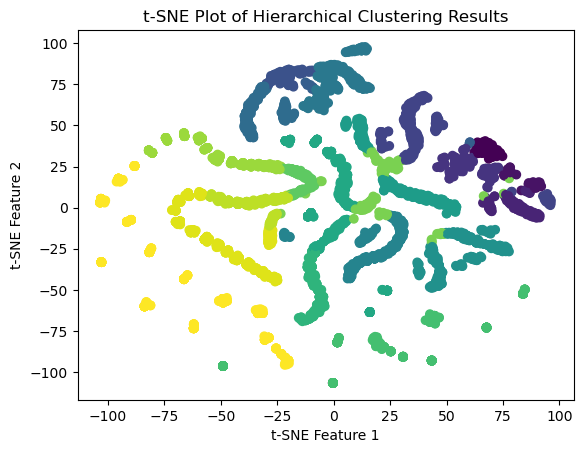

In [56]:
# Create a t-SNE plot to visualize the clusters in a high-dimensional space
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')

X_tsne = tsne.fit_transform(df_scaled)

# Create a scatter plot of the t-SNE embeddings, colored by cluster labels
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df_cluster['Cluster'], cmap='viridis')
plt.title('t-SNE Plot of Hierarchical Clustering Results')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


**4.3 Matrix factorization(NMF)**

In [65]:
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Extract the features to be used in NMF
X = df[["Age", "Gender", "ImpComercial", "ImpSomeonesHouse",'ImpWhenCook']].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_cluster)
X_scaled[X_scaled < 0] = 0

nmf = NMF(n_components=3, init='nndsvda', max_iter=500)
W = nmf.fit_transform(X_scaled)
H = nmf.components_

# Print the resulting factor loadings (H)
print(H)

# Display the resulting clusters
cluster_labels = W.argmax(axis=1)
print(cluster_labels)


[[0.95514588 3.64216723 0.         0.         1.17742969 6.3905437 ]
 [1.20308416 0.         3.77449434 3.88793994 3.76242955 0.7976742 ]
 [0.46244677 3.33483788 2.71973044 1.87405658 1.91777718 0.        ]]
[1 0 0 ... 2 2 2]


In the output provided, the array represents the coefficient matrix 'W' that contains the weights for each data point in each component, where each row represents a single data point and each column represents a single component. The values in the array indicate the relative contribution of each data point to each component.The second array represents the cluster labels assigned to each data point by NMF. In this case, there are three clusters, and each data point is assigned to one of these three clusters.

**4.4 Optimize the k-means**

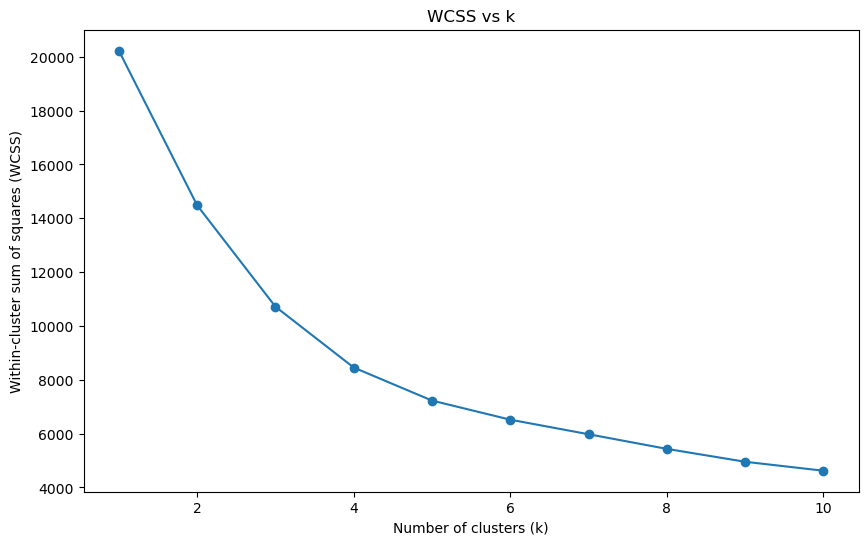

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS vs k graph
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('WCSS vs k')
plt.show()


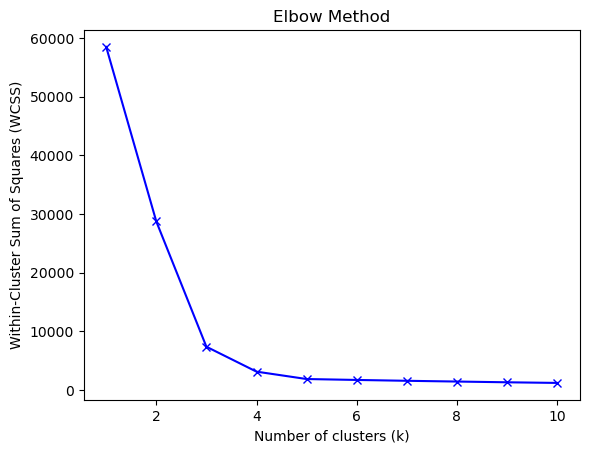

In [61]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate some random data for clustering
X, y = make_blobs(n_samples=1000, centers=5, random_state=42)

# Define the range of k values to test
k_values = range(1, 11)

# Calculate the within-cluster sum of squares (WCSS) for each value of k
wcss_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss_values.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters (k)
plt.plot(k_values, wcss_values, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()


Based on the elbow method, the optimal value for k would be 5 since the curve flattens out after that point, indicating that additional clusters may not significantly improve the performance of the model. However, the choice of k ultimately depends on the specific problem and the trade-off between complexity and performance.

+---------+---------------+------------------+------------------------+----------------------------+-----------------------+
| Cluster | Age (min/max) | Gender (min/max) | ImpComercial (min/max) | ImpSomeonesHouse (min/max) | ImpWhenCook (min/max) |
+---------+---------------+------------------+------------------------+----------------------------+-----------------------+
|    1    |    13 - 46    |      1 - 1       |         4 - 5          |           1 - 5            |         1 - 5         |
|    2    |    14 - 66    |      0 - 0       |         3 - 5          |           2 - 5            |         3 - 5         |
|    3    |    13 - 40    |      1 - 1       |         3 - 5          |           4 - 5            |         4 - 5         |
|    4    |    35 - 79    |      0 - 1       |         4 - 5          |           1 - 5            |         3 - 5         |
|    5    |    12 - 72    |      0 - 1       |         1 - 5          |           1 - 5            |         1 - 5         |


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


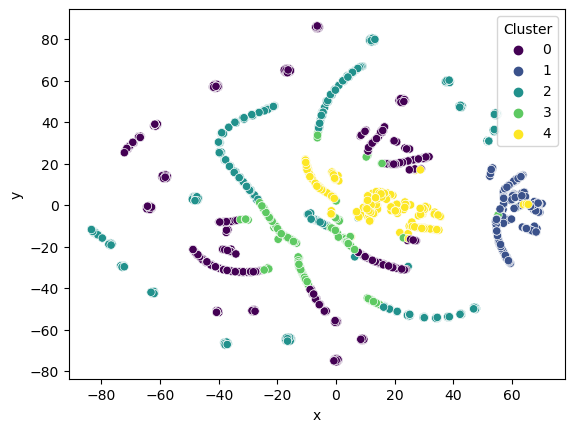

In [64]:
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable

df_cluster = df[["Age", "Gender", "ImpComercial", "ImpSomeonesHouse",'ImpWhenCook']]

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_scaled)
labels = kmeans.labels_

df_cluster = df_cluster.copy()
df_cluster['Cluster'] = labels

# Group the data by the cluster labels
groups = df_cluster.groupby('Cluster')

# Compute the mean, min, and max values for each column in each group
summary = groups.agg(['min', 'max'])


# Create a pretty table for the summary data
table = PrettyTable()
table.field_names = ["Cluster", "Age (min/max)", "Gender (min/max)", 
                     "ImpComercial (min/max)", "ImpSomeonesHouse (min/max)", "ImpWhenCook (min/max)"]

# Add a row for each cluster
for i in range(len(summary)):
    cluster_num = i+1
    age_min = round(summary.iloc[i]['Age']['min'], 2)
    age_max = round(summary.iloc[i]['Age']['max'], 2)
    gender_min = round(summary.iloc[i]['Gender']['min'], 2)
    gender_max = round(summary.iloc[i]['Gender']['max'], 2)
    imp_com_min = round(summary.iloc[i]['ImpComercial']['min'], 2)
    imp_com_max = round(summary.iloc[i]['ImpComercial']['max'], 2)
    imp_house_min = round(summary.iloc[i]['ImpSomeonesHouse']['min'], 2)
    imp_house_max = round(summary.iloc[i]['ImpSomeonesHouse']['max'], 2)
    imp_cook_min = round(summary.iloc[i]['ImpWhenCook']['min'], 2)
    imp_cook_max = round(summary.iloc[i]['ImpWhenCook']['max'], 2)
    
    row_data = [cluster_num, f"{age_min} - {age_max}", f"{gender_min} - {gender_max}",
                f"{imp_com_min} - {imp_com_max}", f"{imp_house_min} - {imp_house_max}",
                f"{imp_cook_min} - {imp_cook_max}"]
    
    table.add_row(row_data)

# Print the table
print(table)


# Fit and transform the data using t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(df_scaled)

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
df_tsne = pd.DataFrame({'x': X_tsne[:, 0], 'y': X_tsne[:, 1], 'Cluster': labels})

sns.scatterplot(data=df_tsne, x='x', y='y', hue='Cluster', palette='viridis')
plt.show()

# 5 Conclusion

In the case of k-means, the number of clusters is chosen beforehand, and the algorithm tries to find the best possible way to divide the data into those clusters. In contrast, hierarchical clustering does not require a pre-defined number of clusters. Instead, it starts with each data point as a separate cluster and then merges them based on the similarity or distance between them, until all the points belong to a single cluster.
Therefore, in the case of hierarchical clustering, the number of clusters obtained can vary based on the threshold distance or similarity level used for merging the clusters. This can result in a larger number of clusters compared to k-means, where the number of clusters is fixed.